* ## Change the python directory to my drive repository

In [0]:
import os
path_drive = "drive/My Drive/PFE /IoT/Edge Computing/"
os.chdir(path_drive)

* ## Importing the necessary libraries:

In [2]:
from utils import *
from AlexNet import BranchyNet

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, AveragePooling2D, Softmax
from tensorflow.keras import Model

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


* ## Initialization the Hyper-Parameters:

In [0]:
# Training parameters
input_shape = (32,32,3)
output_shape = (10,)
BUFFER_SIZE = 500
EPOCHS = 100
BATCH_SIZE = 32

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [0]:
n = 3 
version=1
depth = 20
num_classes = 10
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

* ## Loading the dataset

In [5]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


* ## Useful Functions:

* ## Loading The Model:

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    exit1 = x
    exit1 = Conv2D(num_filters, 3, padding="valid")(exit1)
    exit1 = Flatten()(exit1)
    exit1 = Dense(num_classes,
                  activation='softmax',
                  name="Exit_1")(exit1)

    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        
        if stack==0:
            # ----- FIRST BRANCH ------
            exit2 = x
            exit2 = Conv2D(num_filters, 3, padding="valid")(exit2)
            exit2 = Flatten()(exit2)
            exit2 = Dense(num_classes,
                          activation='softmax',
                          name="Exit_2")(exit2)

        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    y = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal', 
                    name="Exit_3")(y)
    
    outputs = [exit1, exit2, y]

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

* ## Compile the model:

In [10]:
model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
# model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

Learning rate:  0.001
ResNet20v1


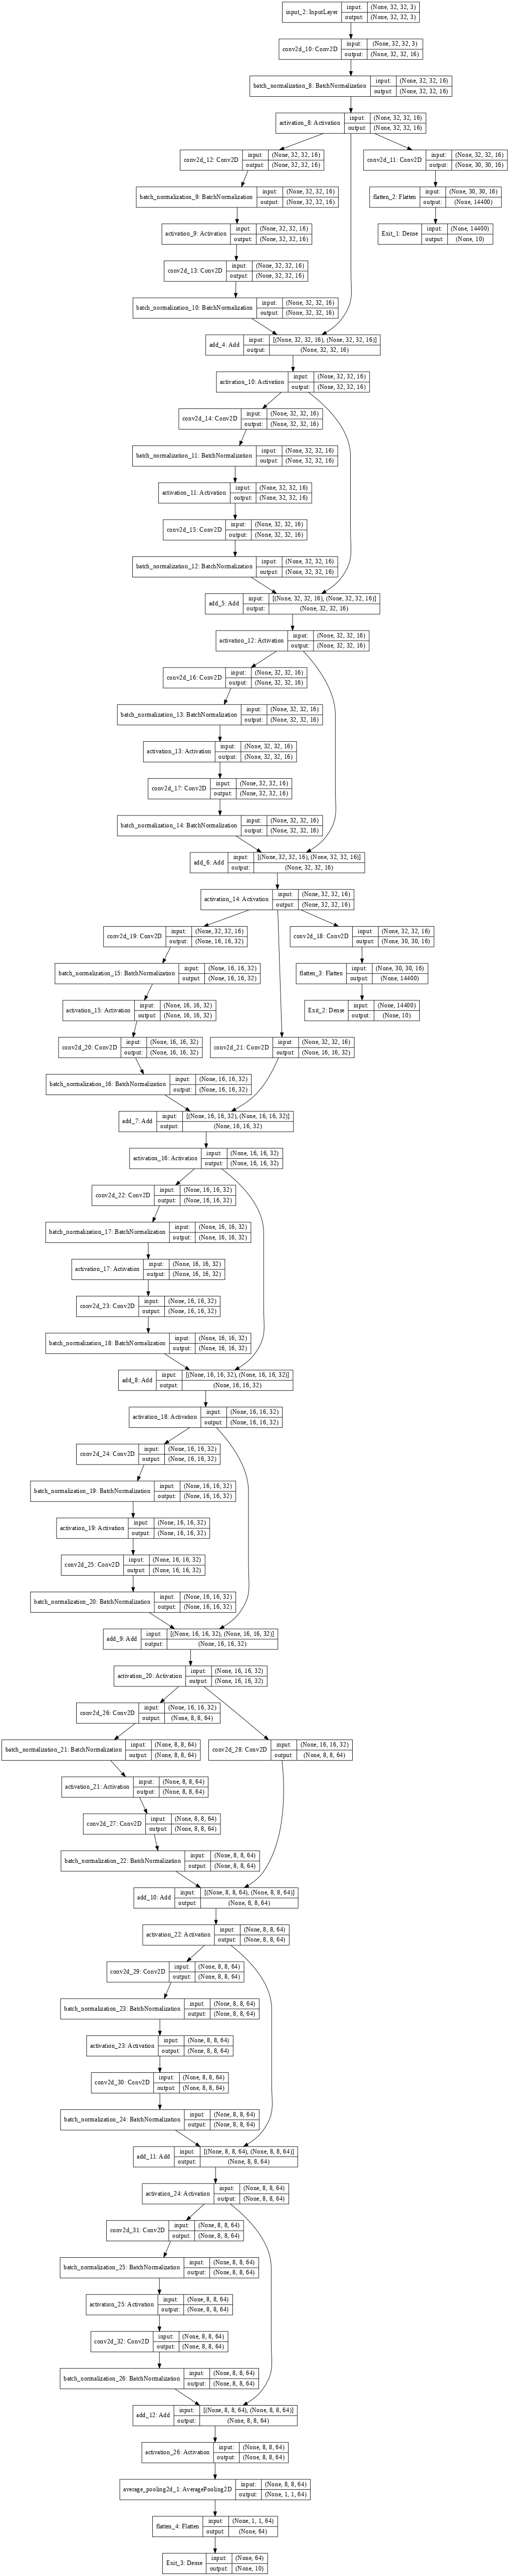

In [11]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

* ## Training Phase:

In [0]:
print('Not using data augmentation.')
model.fit(x_train,
          3*[y_train],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, 
                            3*[y_test]),
          shuffle=True,
          callbacks=callbacks)

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
Learning rate:  0.001
50000/50000 [==============================] - 121s 2ms/step - loss: 4.7109 - Exit_1_loss: 1.5883 - Exit_2_loss: 1.5889 - Exit_3_loss: 1.3759 - Exit_1_accuracy: 0.4593 - Exit_2_accuracy: 0.4723 - Exit_3_accuracy: 0.5039 - val_loss: 3.8392 - val_Exit_1_loss: 1.3743 - val_Exit_2_loss: 1.2225 - val_Exit_3_loss: 1.0845 - val_Exit_1_accuracy: 0.5249 - val_Exit_2_accuracy: 0.5753 - val_Exit_3_accuracy: 0.6073
Epoch 2/100
Learning rate:  0.001
   96/50000 [..............................] - ETA: 1:36 - loss: 2.9717 - Exit_1_loss: 1.0518 - Exit_2_loss: 0.8386 - Exit_3_loss: 0.9232 - Exit_1_accuracy: 0.5938 - Exit_2_accuracy: 0.7604 - Exit_3_accuracy: 0.6667

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


50000/50000 [==============================] - 108s 2ms/step - loss: 3.4832 - Exit_1_loss: 1.2497 - Exit_2_loss: 1.0921 - Exit_3_loss: 0.9813 - Exit_1_accuracy: 0.5702 - Exit_2_accuracy: 0.6221 - Exit_3_accuracy: 0.6541 - val_loss: 3.9933 - val_Exit_1_loss: 1.4020 - val_Exit_2_loss: 1.1639 - val_Exit_3_loss: 1.2640 - val_Exit_1_accuracy: 0.5273 - val_Exit_2_accuracy: 0.5954 - val_Exit_3_accuracy: 0.5620
Epoch 3/100
Learning rate:  0.001
50000/50000 [==============================] - 107s 2ms/step - loss: 2.9615 - Exit_1_loss: 1.0834 - Exit_2_loss: 0.9063 - Exit_3_loss: 0.8056 - Exit_1_accuracy: 0.6267 - Exit_2_accuracy: 0.6862 - Exit_3_accuracy: 0.7178 - val_loss: 3.7200 - val_Exit_1_loss: 1.4481 - val_Exit_2_loss: 1.1498 - val_Exit_3_loss: 0.9520 - val_Exit_1_accuracy: 0.5201 - val_Exit_2_accuracy: 0.6168 - val_Exit_3_accuracy: 0.6811
Epoch 4/100
Learning rate:  0.001
50000/50000 [==============================] - 107s 2ms/step - loss: 2.6412 - Exit_1_loss: 0.9748 - Exit_2_loss: 0.785